In [8]:
library(SeuratDisk)
library(Seurat)
library(glue)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message:
“package ‘glue’ was built under R version 4.0.5”


obtained top 2k most variable genes per cell type --> intersected these lists --> outputted counts for that intersecting dataset

In [2]:
exp <- LoadH5Seurat("/PHShome/sv433/scratch/MORABITO/RNA/RNA_expression_mat_scaled_batch_regressed_with_metadata_10000_vargenes.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding variable feature information for RNA

Adding miscellaneous information for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [3]:
meta = read.csv("/PHShome/sv433/scratch/MORABITO/RNA/data/snRNA_metadta.csv")

In [4]:
# obtain log normalized data
exp = exp@assays$RNA@data
dim(exp)

[1] 36066 61472

Inspect Genes

In [5]:
# compute gene means and standard deviations
mus = apply( exp , 1 , mean )
sds = apply( exp , 1 , sd )

glue("No. of mus should match number of genes: {length(mus)}")

glue("Nonzero mus count: {sum(mus!=0)}")


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 16.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 16.5 GiB”


No. of mus should match number of genes: 36066

Nonzero mus count: 36066

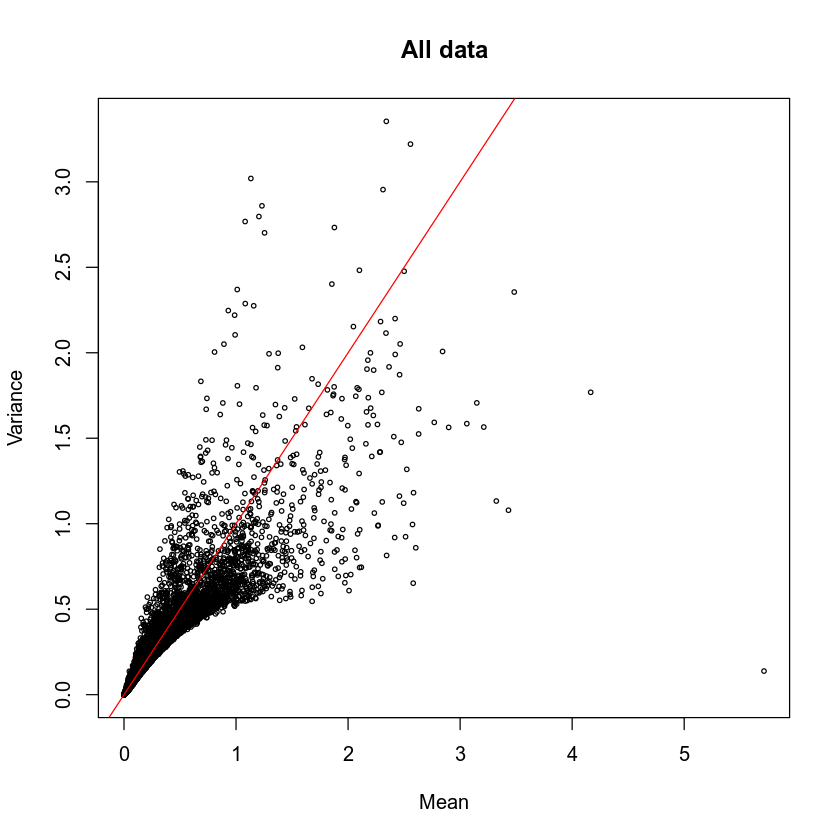

In [6]:
# plot mu vs sd of genes to identify outlier cutoffs
keep = sds > 0 # filter out standard devations of 0
plot( mus[keep] , sds[keep]^2 , xlab="Mean" , ylab="Variance" , cex=0.5, main="All data" )
abline(0,1,, col="red")

Mean log-norm expression of genes kept: 0.99428824932069

Number of genes retained: 35860

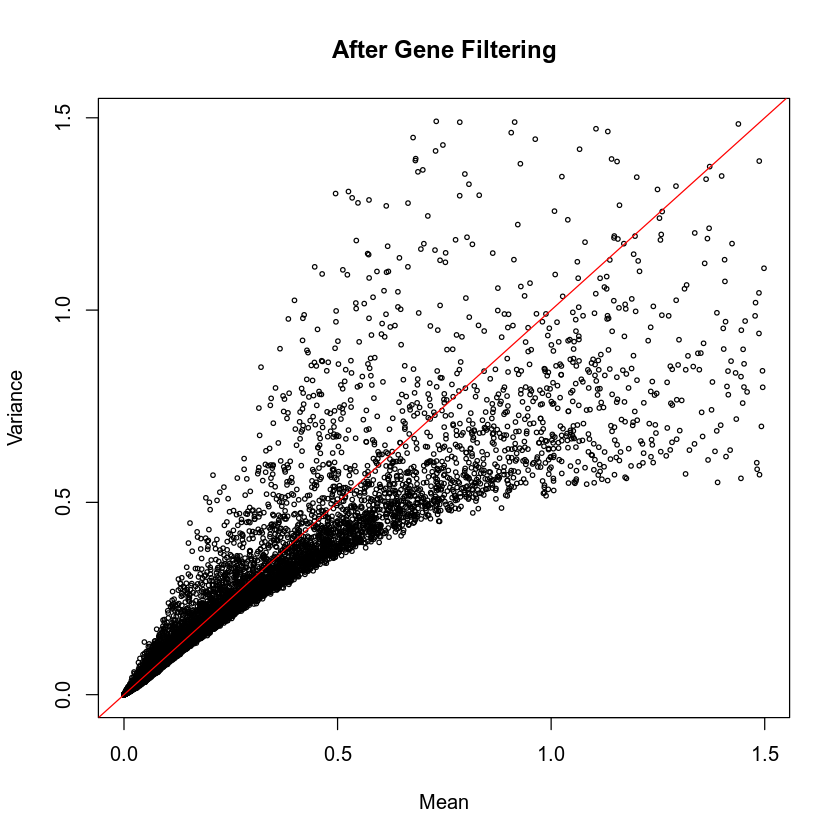

In [7]:
# remove outlier genes with extreme expression
genes.keep = sds > 0 & sds^2 < 1.5 & mus < 1.5
glue("Mean log-norm expression of genes kept: {mean(genes.keep)}")
plot( mus[genes.keep] , sds[genes.keep]^2 , xlab="Mean" , ylab="Variance" , cex=0.5 , main="After Gene Filtering")
abline(0,1,, col="red")
glue("Number of genes retained: {sum(genes.keep)}")


Inspect Cells

In [8]:
# plot number of expressed genes per cell
ngenes = apply( exp[genes.keep,] != 0 , 2 , sum )

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 8.2 GiB”


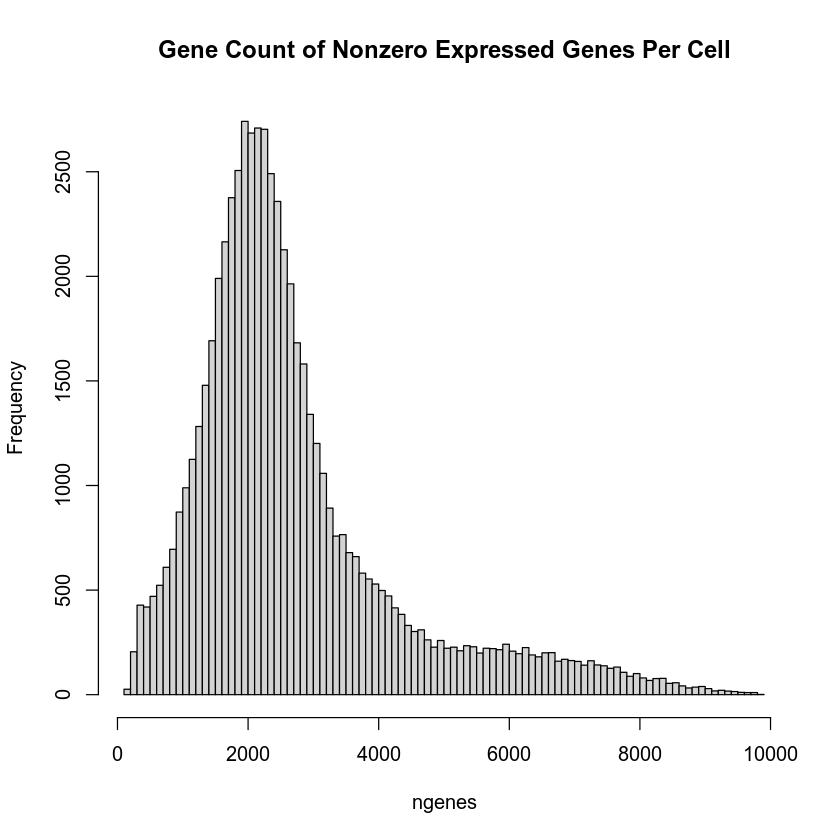

In [9]:
#hist(ngenes[!is.na(meta$maintype)],breaks=100)
# MAY WANT TO FILTER THE RIGHT TAIL
hist(ngenes,breaks=100, main="Gene Count of Nonzero Expressed Genes Per Cell")

In [18]:
cells.keep = ngenes > 500 
mean(cells.keep)

[1] 0.9824636

In [19]:
# now subset expression matrix to retained cells and genes
exp = exp[genes.keep,cells.keep]
dim(exp)

[1] 35860 60394

In [20]:
# create seurat object with filtered data
exp = CreateSeuratObject(counts=exp)

In [22]:
# filter metadata
meta = meta[colnames(exp),]
dim(meta)

[1] 60394    10

In [33]:
save(exp, meta, file = "/PHShome/sv433/scratch/MORABITO/RNA/prefiltered_Morabito_RNA_log_norm.RData")

Outputting Counts Data For Gamma-Poisson Simulation --> selecting most variable genes across cell types

In [34]:
load("/PHShome/sv433/scratch/MORABITO/RNA/prefiltered_Morabito_RNA_log_norm.RData")
dim(exp)
head(meta)

[1] 35860 60394

,Sample.ID,Batch,Sex,Age,Diagnosis,UMAP_1,UMAP_2,cluster,celltype
,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
AAACCCAAGAAGCTCG-1,Sample-19,3,F,90,AD,-0.4390070,8.746606,ODC9,ODC
AAACCCAAGGATGCGT-1,Sample-19,3,F,90,AD,5.1486110,11.073421,ODC7,ODC
AAACGAAGTTCGAAGG-1,Sample-19,3,F,90,AD,-0.2490346,6.647623,ODC1,ODC
AAAGAACGTATTCCGA-1,Sample-19,3,F,90,AD,-1.2946340,8.344845,ODC2,ODC
AAAGGATAGGCCTAAG-1,Sample-19,3,F,90,AD,-0.3498507,10.167821,ODC9,ODC
AAAGGATTCAAGTGTC-1,Sample-19,3,F,90,AD,0.6490863,7.593547,ODC1,ODC


In [38]:
exp <- AddMetaData(
  object = exp,
  metadata = meta
)

In [40]:
# GOAL: find top variable genes in cell type and concatenate them into a list so that counts from those genes can be exported
num_var_feat_per_ct = 500
var_genes_across_ct = c()

celltypes = unique(exp@meta.data$celltype)

for (ct in celltypes){
    # subset expression matrix to cell type
    sub = subset(x = exp, subset = celltype == ct)
    # identify variable geens
    sub = FindVariableFeatures(sub, selection.method = "vst", nfeatures = num_var_feat_per_ct)
    var_genes = VariableFeatures(sub)
    # append to master list
    var_genes_across_ct = append(var_genes_across_ct, var_genes) 
}

# remove duplicates
var_genes_across_ct = unique(var_genes_across_ct)



In [41]:
length(var_genes_across_ct)

[1] 2527

In [46]:
# export counts so that they can be fitted to the simulation
sub_cells = rownames(exp@meta.data)
batch = exp@meta.data$Batch
cell_type = exp@meta.data$celltype
# load original counts matrix
exp <- LoadH5Seurat("/PHShome/sv433/scratch/MORABITO/RNA/RNA_expression_mat_scaled_batch_regressed_with_metadata_10000_vargenes.h5Seurat")
counts = exp@assays$RNA@counts
counts = counts[var_genes_across_ct,sub_cells]
dim(counts)

output = x <- list("counts" = counts, "cell_type" = cell_type, "batch" = batch)
saveRDS(output, "/PHShome/sv433/scratch/MORABITO/RNA/RNA_counts_ct_batch.RDS")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding variable feature information for RNA

Adding miscellaneous information for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



[1]  2527 60394

In [51]:
dim(exp@meta.data)
dim(counts)
length(cell_type)
length(batch)
length(sub_cells)
sub_cells

[1] 61472     5

[1]  2527 60394

[1] 60394

[1] 60394

[1] 60394

[1] "AAACCCAAGAAGCTCG-1"  "AAACCCAAGGATGCGT-1"  "AAACGAAGTTCGAAGG-1" 
    [4] "AAAGAACGTATTCCGA-1"  "AAAGGATAGGCCTAAG-1"  "AAAGGATTCAAGTGTC-1" 
    [7] "AAAGGTATCAGATGCT-1"  "AAAGGTATCGGAATGG-1"  "AAAGTCCCATACCAGT-1" 
   [10] "AAAGTCCCATGGAAGC-1"  "AAAGTCCCATTCATCT-1"  "AAAGTCCGTCGTTGCG-1" 
   [13] "AAAGTCCTCGAATCCA-1"  "AAATGGACAATAAGGT-1"  "AAATGGATCAGATGCT-1" 
   [16] "AACAAGATCACCTGTC-1"  "AACAAGATCCGATGCG-1"  "AACACACCACGGAAGT-1" 
   [19] "AACACACCATCCCGTT-1"  "AACACACGTCGAAGCA-1"  "AACAGGGAGACAAGCC-1" 
   [22] "AACCACACATGAGATA-1"  "AACCACAGTAGCTGAG-1"  "AACCATGTCCCTCGTA-1" 
   [25] "AACCCAACATGAATAG-1"  "AACCCAATCCGATTAG-1"  "AACCTTTTCTGGCCAG-1" 
   [28] "AACGAAAAGCAACTTC-1"  "AACGAAATCAACGAGG-1"  "AACGTCAAGAAGGTAG-1" 
   [31] "AACGTCAAGTAGAGTT-1"  "AACGTCAAGTGGTTGG-1"  "AACGTCATCACTGTCC-1" 
   [34] "AACTTCTAGGTAAGGA-1"  "AACTTCTCAATAGTGA-1"  "AACTTCTGTCGAACGA-1" 
   [37] "AACTTCTGTTCAAGTC-1"  "AAGAACAGTGACATCT-1"  "AAGAACAGTGTCACAT-1" 
   [40] "AAGAACAGTTTGGCTA-1"  "AAGATAGGTACTAACC-1"  "AAGCATCAGACTCAAA-1" 
   [43] "AAGCATCAGTCATGCT-1"  "AAGCGAGAGCGCTGCT-1"  "AAGCGAGAGGTGTGAC-1" 
   [46] "AAGCGAGCAAGTTGGG-1"  "AAGCGAGGTCTGTGTA-1"  "AAGCGTTGTGATTAGA-1" 
   [49] "AAGGAATCAAATACAG-1"  "AAGGAATGTGTCCACG-1"  "AAGGTAAAGCGATTCT-1" 
   [52] "AAGGTAAGTTACGATC-1"  "AAGGTAAGTTGCAACT-1"  "AAGTACCAGCCATTTG-1" 
   [55] "AAGTACCCAGGTTCAT-1"  "AAGTACCTCCGGCTTT-1"  "AAGTACCTCGAAGCCC-1" 
   [58] "AAGTCGTCAGTGTGGA-1"  "AAGTCGTTCAGCAATC-1"  "AAGTCGTTCTTCCGTG-1" 
   [61] "AAGTGAACATCGATGT-1"  "AAGTGAATCCATTGTT-1"  "AATAGAGAGACGCATG-1" 
   [64] "AATAGAGAGGTATTGA-1"  "AATAGAGGTGGTACAG-1"  "AATCACGAGGAACGTC-1" 
   [67] "AATCACGCATGACTGT-1"  "AATCACGGTACAGTCT-1"  "AATCGACGTGGTAACG-1" 
   [70] "AATCGACTCTTTCTAG-1"  "AATCGTGAGCCATTCA-1"  "AATCGTGCAAGGCAAC-1" 
   [73] "AATCGTGGTGCAGATG-1"  "AATCGTGTCTAAGCCA-1"  "AATGAAGCATATGCGT-1" 
   [76] "AATGAAGGTAATTGGA-1"  "AATGACCAGAGCTGAC-1"  "AATGACCGTCTCCCTA-1" 
   [79] "AATGCCAAGAATCGTA-1"  "AATGCCAAGTCTACCA-1"  "AATGGAATCAGCTGAT-1" 
   [82] "AATGGCTCATAATGAG-1"  "AATGGCTCATATAGCC-1"  "AATGGCTGTGGAAATT-1" 
   [85] "AATGGCTGTGGTCCCA-1"  "AATGGCTTCCAATCTT-1"  "AATGGCTTCGACGAGA-1" 
   [88] "AATTCCTAGTCGCCAC-1"  "AATTCCTTCGCAATTG-1"  "AATTTCCAGTATTCCG-1" 
   [91] "AATTTCCCACACGTGC-1"  "ACAAAGACAAGTGCTT-1"  "ACAACCAAGACCTGGA-1" 
   [94] "ACAACCATCCCTTGTG-1"  "ACACAGTCATATGGCT-1"  "ACACCAACACCCAAGC-1" 
   [97] "ACACGCGGTACGGGAT-1"  "ACACTGACAAAGCGTG-1"  "ACACTGACAACAAAGT-1" 
  [100] "ACACTGATCCGATCTC-1"  "ACAGAAACAGCTGAGA-1"  "ACAGAAAGTACCTTCC-1" 
  [103] "ACAGCCGTCTATGTGG-1"  "ACAGCCGTCTGCTCTG-1"  "ACAGGGAGTAATCAAG-1" 
  [106] "ACATCCCCAGACAAAT-1"  "ACATCCCGTCTAACGT-1"  "ACATGCAAGCGTATAA-1" 
  [109] "ACATTTCCAGAGATGC-1"  "ACCACAACATGAATCC-1"  "ACCCTCAAGTTGAATG-1" 
  [112] "ACCCTCAGTAACACCT-1"  "ACCCTCAGTCCCGTGA-1"  "ACCCTCATCGGAGATG-1" 
  [115] "ACCGTTCCACGGGCTT-1"  "ACCTGAACAGACGCTC-1"  "ACCTGAACAGCGTTTA-1" 
  [118] "ACCTGTCGTTTCGATG-1"  "ACCTGTCTCGGACAAG-1"  "ACGATCAAGTTCCATG-1" 
  [121] "ACGATCACAAGGCAAC-1"  "ACGATGTGTCTCAAGT-1"  "ACGCACGAGAGTCACG-1" 
  [124] "ACGCACGCAGTGTACT-1"  "ACGCACGGTGCAGGAT-1"  "ACGCACGGTGGTATGG-1" 
  [127] "ACGCACGTCAACTACG-1"  "ACGGAAGAGTGGCGAT-1"  "ACGGAAGCAAGTTCGT-1" 
  [130] "ACGGGTCAGGTCCCGT-1"  "ACGGGTCGTTGTTTGG-1"  "ACGTAACGTAGTCTTG-1" 
  [133] "ACGTAGTAGGCACAAC-1"  "ACGTAGTGTAATTAGG-1"  "ACGTCCTTCGACATAC-1" 
  [136] "ACGTTCCAGGCTCTAT-1"  "ACGTTCCTCTAAGAAG-1"  "ACTACGATCGTGGAAG-1" 
  [139] "ACTATCTAGAAACACT-1"  "ACTATCTAGATGACCG-1"  "ACTATTCCAAACTCGT-1" 
  [142] "ACTCTCGTCGCAACAT-1"  "ACTGATGCACCGCTAG-1"  "ACTGCAACAACAGCCC-1" 
  [145] "ACTGCAACATGAATAG-1"  "ACTGCAAGTCCCTCAT-1"  "ACTGTCCTCATGTCAG-1" 
  [148] "ACTGTGACATGCGTGC-1"  "ACTTAGGGTAGACGTG-1"  "ACTTAGGGTCTCGGAC-1" 
  [151] "ACTTCGCAGTAGCTCT-1"  "ACTTCGCCAGCTCGGT-1"  "ACTTTCACAAGTCCAT-1" 
  [154] "ACTTTCACACTCACTC-1"  "ACTTTCATCGCAGTTA-1"  "ACTTTGTGTAAGGCTG-1" 
  [157] "AGAACCTAGGGAGGCA-1"  "AGAACCTTCGGTAGAG-1"  "AGAAGCGAGAATCGCG-1" 
  [160] "AGAAGCGCACAAGCAG-1"  "AGAAGCGTCAAATAGG-1"  "AGAAGCGTCTGCTCTG-1" 
  [163] 

In [20]:
# exp <- FindVariableFeatures(exp, selection.method = "vst", nfeatures = 3000)
# sub_genes = VariableFeatures(exp) 
# sub_cells = rownames(exp@meta.data)
# batch = exp@meta.data$batch
# counts = exp@assays$RNA@counts
# counts = counts[sub_genes,sub_cells]
# dim(counts) 
# cell_type = exp@meta.data$celltype
# output = x <- list("counts" = counts, "cell_type" = cell_type, "batch" = batch)
# saveRDS(output, "/PHShome/sv433/scratch/MORABITO/RNA/RNA_counts_ct_batch.RDS")

In [52]:
counts

  [[ suppressing 32 column names ‘AAACCCAAGAAGCTCG-1’, ‘AAACCCAAGGATGCGT-1’, ‘AAACGAAGTTCGAAGG-1’ ... ]]



2527 x 60394 sparse Matrix of class "dgCMatrix"
                                                                             
AL390334.1       .  . .  .  .  2  .  . .  .  .  .  .  .  .  .  . .  .  .  . .
SGCZ             .  . .  .  .  .  .  3 .  .  .  .  .  .  .  .  . .  .  .  . .
CARMN            .  . .  .  .  .  .  . .  .  .  .  .  .  .  .  . .  .  .  . .
LINC01505        3  2 .  .  .  1  .  . .  .  .  .  .  .  .  .  . .  .  .  5 .
AC012593.1       .  6 .  1  .  .  3  1 .  .  .  .  .  .  .  .  . .  .  .  . .
C5orf17          .  4 3  .  .  .  1  6 4  .  .  1  .  .  .  .  1 .  .  .  . .
LAMA2            .  . .  .  .  3  .  5 1  3  1  . 13  6  2  4  . .  4  1  . .
CLNS1AP1         .  . .  .  .  .  .  . .  .  .  .  .  .  .  .  . .  .  .  . .
LINC01170        3  2 2  .  .  .  5  . 4 12  .  .  .  .  .  .  . .  .  .  . .
DCC              5  . .  . 12  2  3  . .  7  .  .  .  4  .  7  1 . 29  . 20 5
KCNAB1           .  . .  .  .  .  .  . 4  .  .  .  .  .  3  .  . .  .  .  . 6
PTPRM           

Outputting Counts Data For Gamma-Poisson Simulation --> selecting random genes equivalent to most variable genes selected in previous section

In [1]:
load("/PHShome/sv433/scratch/MORABITO/RNA/prefiltered_Morabito_RNA_log_norm.RData")
dim(exp)
head(meta)
num_genes_to_sample = 2527

Loading required package: SeuratObject

Loading required package: sp



[1] 35860 60394

,Sample.ID,Batch,Sex,Age,Diagnosis,UMAP_1,UMAP_2,cluster,celltype
,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
AAACCCAAGAAGCTCG-1,Sample-19,3,F,90,AD,-0.4390070,8.746606,ODC9,ODC
AAACCCAAGGATGCGT-1,Sample-19,3,F,90,AD,5.1486110,11.073421,ODC7,ODC
AAACGAAGTTCGAAGG-1,Sample-19,3,F,90,AD,-0.2490346,6.647623,ODC1,ODC
AAAGAACGTATTCCGA-1,Sample-19,3,F,90,AD,-1.2946340,8.344845,ODC2,ODC
AAAGGATAGGCCTAAG-1,Sample-19,3,F,90,AD,-0.3498507,10.167821,ODC9,ODC
AAAGGATTCAAGTGTC-1,Sample-19,3,F,90,AD,0.6490863,7.593547,ODC1,ODC


In [2]:
random_genes = sample(rownames(exp), size = num_genes_to_sample, replace = FALSE) 

In [16]:
# export counts so that they can be fitted to the simulation
sub_cells = rownames(exp@meta.data)
batch = exp@meta.data$Batch
cell_type = exp@meta.data$celltype
# load original counts matrix
exp <- LoadH5Seurat("/PHShome/sv433/scratch/MORABITO/RNA/RNA_expression_mat_scaled_batch_regressed_with_metadata_10000_vargenes.h5Seurat")
counts = exp@assays$RNA@counts
counts = counts[random_genes,sub_cells]
dim(counts)

output = x <- list("counts" = counts, "cell_type" = cell_type, "batch" = batch)
saveRDS(output, "/PHShome/sv433/scratch/MORABITO/RNA/RNA_counts_random_batch.RDS")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding variable feature information for RNA

Adding miscellaneous information for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



[1]  2527 61472